In [142]:
import torch
from torch import nn
from torch.nn import functional as F
import pandas as pd
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


from sklearn.metrics import confusion_matrix

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device is", device)

classes = ('g','r','n')

device is cpu


In [143]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [144]:
# image: input size 160x120
# out: one-hot [Green, Red, None]
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.act = nn.ReLU()
        self.sig = nn.Softmax()
        
        # input: 160x120x3
        self.conv11 = nn.Conv2d(3, 9, kernel_size=7, padding=0) # output: 154x114x6
        self.conv12 = nn.Conv2d(9, 16, kernel_size=7, padding=0) # output: 148x108x6
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)      # output: 74x54x6

        self.conv21 = nn.Conv2d(16, 16, kernel_size=7, padding=0) # output: 68x48x3
        self.conv22 = nn.Conv2d(16, 16, kernel_size=7, padding=0) # output: 62x42x1
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)      # output: 31x21x1

        self.fc1 = nn.Linear(16*31*21,1000)
        self.fc2 = nn.Linear(1000,100)
        self.fc3 = nn.Linear(100,10)
        self.fc4 = nn.Linear(10,3)

        self.drop = nn.Dropout(p=0.3)
    
    def forward(self, x):
        x = self.conv11(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.conv12(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.pool1(x)

        x = self.conv21(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.conv22(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.pool2(x)

        x = torch.flatten(x,start_dim=1)

        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc3(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc4(x)

        return x

In [145]:
class CaptionDataset(torch.utils.data.Dataset):
    def __init__(self, dir, transform=None):
        self.image_dir = os.path.join(dir,"Images2")
        self.df = pd.read_csv(os.path.join(dir,"labels2.txt"))
        self.transform = transform

    def __getitem__(self,i,transform=None):              
        label = self.df["label"][i]
        if label=="g":
            label = torch.tensor([1,0,0])
        if label=="r":
            label = torch.tensor([0,1,0])
        if label=="n":
            label = torch.tensor([0,0,1])
        image_path = os.path.join(self.image_dir,self.df["image"][i])
        image = transforms.ToTensor()(Image.open(image_path))
        if self.transform!=None:
            image = self.transform(image)
        return (image,label)

    def __len__(self):
        return len(self.df)

In [146]:
transform = transforms.Compose([
    transforms.Resize((120,160)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

augment = transforms.Compose([
    transforms.RandomVerticalFlip(p=0.5)
])

In [147]:
ds = CaptionDataset("data", transform=transform)

train_size = int(0.7 * len(ds))
val_size = int(0.15 * len(ds))
test_size = len(ds) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(ds, [train_size, val_size, test_size])

train_loader = DataLoader(train_set,batch_size=15,shuffle=True)
val_loader = DataLoader(val_set,batch_size=15,shuffle=True)
test_loader = DataLoader(test_set,batch_size=15,shuffle=True)
it = iter(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 0, 0])


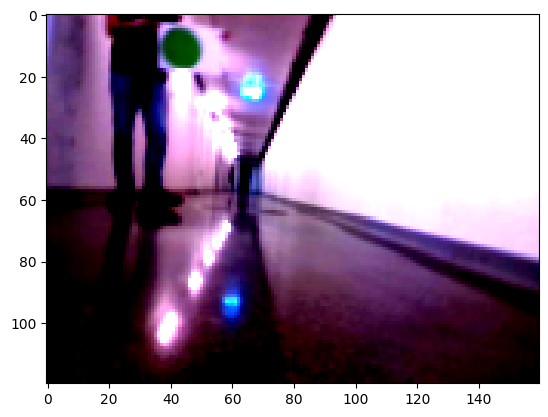

In [148]:
(images,labels) = next(it)
plt.imshow(images[0].permute(1, 2, 0))
print(labels[0])

In [149]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, scheduler):
    best_val_loss = float('inf')
    best_model = model

    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch+1} of {num_epochs}")
        model.train()
        train_loss = 0.0
        for batch_nr, (inputs, labels) in enumerate(train_loader):
            if (batch_nr%7 == 0):
                print(f"Processing batch number {batch_nr+1} of {len(train_loader)}")
            inputs = augment(inputs)
            inputs = inputs.to(device)
            labels = labels.to(device).to(torch.float)
            optimizer.zero_grad()
            outputs = model(inputs).to(torch.float)
            #print(nn.Softmax()(outputs))
            #print(labels)
            loss = criterion(outputs, labels)
            loss = loss.to(device)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        
        train_loss /= len(train_loader.dataset)
        scheduler.step()
    
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).to(torch.float)
                outputs = model(inputs).to(torch.float)
            
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        
        val_loss /= len(val_loader.dataset)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            torch.save(best_model, "CNN_model2.pt")
    return best_model

def test_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        test_loss = 0.0
        correct = 0
        total = 0
        all_predictions = []
        all_targets = []

        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).to(torch.float)
            labels = labels.to(torch.float)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            predicted = torch.argmax(outputs,dim=1)
            total += labels.size(0)
            labels = torch.argmax(labels,dim=1)
            for image, pred, label, output in zip(inputs, predicted, labels, outputs):
                if pred!=label:
                    print("label:",label.item())
                    print("prediction:",pred.item())
                    print("output:",nn.Softmax()(output).tolist())
                    plt.imshow(image.permute(1,2,0))
                    plt.show()
            print(predicted)
            print(labels)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

        test_loss /= len(test_loader.dataset)
        accuracy = 100 * correct / total
        
        # Calculate confusion matrix
        conf_matrix = confusion_matrix(all_targets, all_predictions)

    return test_loss, accuracy, conf_matrix

cpu


C:\Users\Anton\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 2
output: [0.07597427815198898, 0.3533722460269928, 0.5706534385681152]


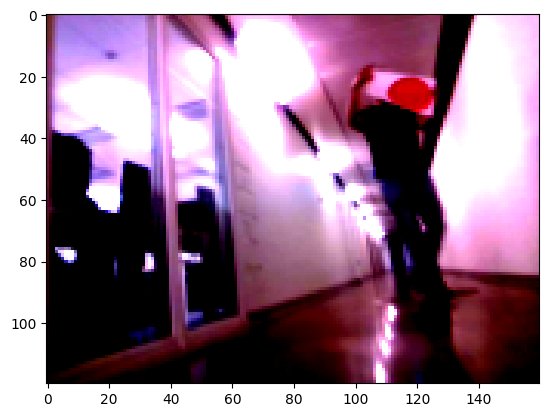

tensor([1, 2, 2, 1, 2, 1, 1, 0, 1, 2, 2, 2, 1, 1, 0])
tensor([1, 2, 2, 1, 2, 1, 1, 0, 1, 2, 2, 1, 1, 1, 0])
tensor([0, 2, 1, 1, 0, 2, 1, 0, 0, 1, 2, 1, 2, 2, 2])
tensor([0, 2, 1, 1, 0, 2, 1, 0, 0, 1, 2, 1, 2, 2, 2])
tensor([0, 0, 1, 1, 1, 1, 2, 1, 0, 0, 2, 2, 2, 1, 1])
tensor([0, 0, 1, 1, 1, 1, 2, 1, 0, 0, 2, 2, 2, 1, 1])
tensor([2, 2, 2, 2, 1, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2])
tensor([2, 2, 2, 2, 1, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2])
tensor([1, 0, 1, 2, 1, 1, 0, 0, 0, 1, 0, 2, 2, 2, 2])
tensor([1, 0, 1, 2, 1, 1, 0, 0, 0, 1, 0, 2, 2, 2, 2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 2
output: [0.006172461900860071, 0.030796656385064125, 0.9630309343338013]


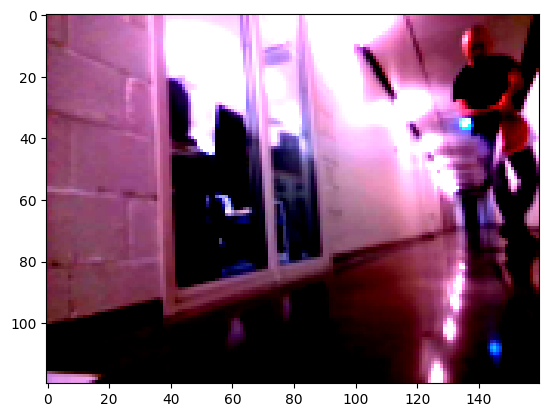

tensor([1, 2, 1, 0, 1, 2, 0, 2, 0, 0, 1, 1, 0, 2, 2])
tensor([1, 2, 1, 0, 1, 1, 0, 2, 0, 0, 1, 1, 0, 2, 2])
tensor([0, 2, 2, 2, 2, 0, 2, 1, 0, 0, 0, 2])
tensor([0, 2, 2, 2, 2, 0, 2, 1, 0, 0, 0, 2])
Test Loss: 0.0059, Test Accuracy: 98.04%
Confusion matrix, without normalization


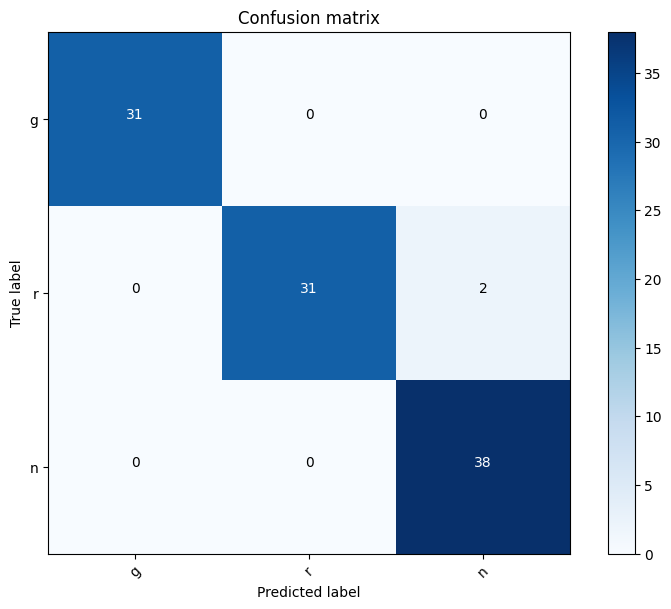

In [151]:
LEARNING_RATE = 0.001
EPOCHS = 100

print(device)
#model = CNN().to(device)
#model = torch.load("CNN_model2.pt")
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([1,1.187234,1.256756])).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.0001)
scheduler  = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

# Train the model
#trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, EPOCHS, scheduler)
#trained_model = torch.load("CNN_model.pt")
# Test the model
test_loss, test_accuracy, conf_matrix = test_model(model, test_loader, criterion)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix, classes=classes, normalize=False)
plt.show()

In [107]:
image, label = next(it)

In [108]:
from time import perf_counter

In [132]:
model = torch.jit.load('model_scripted2.pt')
print(label[0])
print(image.shape)
img = torch.unsqueeze(image[0],dim=0)
pred=0
t1_start = perf_counter() 
pred = torch.argmax(model(img))
t1_stop = perf_counter() 
print(pred)
print(t1_stop-t1_start)

tensor([0, 0, 1])
torch.Size([15, 3, 120, 160])
tensor(2)
0.016806399999950372


In [152]:
# Saving model
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted2.pt') # Save

# Loading model
model = torch.jit.load('model_scripted2.pt')
model.eval()

RecursiveScriptModule(
  original_name=CNN
  (act): RecursiveScriptModule(original_name=ReLU)
  (sig): RecursiveScriptModule(original_name=Softmax)
  (conv11): RecursiveScriptModule(original_name=Conv2d)
  (conv12): RecursiveScriptModule(original_name=Conv2d)
  (pool1): RecursiveScriptModule(original_name=MaxPool2d)
  (conv21): RecursiveScriptModule(original_name=Conv2d)
  (conv22): RecursiveScriptModule(original_name=Conv2d)
  (pool2): RecursiveScriptModule(original_name=MaxPool2d)
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (fc3): RecursiveScriptModule(original_name=Linear)
  (fc4): RecursiveScriptModule(original_name=Linear)
  (drop): RecursiveScriptModule(original_name=Dropout)
)